In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
pd.set_option('mode.chained_assignment',None)
import glob
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from IPython.display import display
import numpy as np
%matplotlib inline

In [3]:
def split_model(df, model_name=None):
  if model_name:
    model_df = df[df.model==model_name]
  else:
    model_df = df.copy()
  td_model_df = model_df[~model_df["mode"].str.contains("baseline")]
  baseline_df = model_df[model_df["mode"].str.contains("baseline")]
  return td_model_df, baseline_df

In [ ]:
def make_color_lookup(df, cmap=plt.cm.cool, key="td"):
  unique_tds = np.sort(td_model_df[key].unique())
  cmap_colors = cmap(np.linspace(0, 1, len(unique_tds)+2))[1:-1][:,:3]
  color_lookup = {key: cmap_colors[i] for i, key in enumerate(unique_tds)}
  return color_lookup

In [ ]:
def scatter_line_plot(df, ls='-', lw=2, color=None, palette=None, alpha=0.5):
    sns.lineplot(
        x="t", 
        y="val", 
        hue="td", 
        data=df,
        palette=palette, 
        linestyle=ls,
        color=color,
        linewidth=lw,
        alpha=alpha,
    )
    sns.scatterplot(
        x="t", 
        y="val", 
        hue="td",
        data=df,
        palette=palette, 
        color=color,
    )

In [ ]:
def set_best_and_asymptotic_vals(df, title, show_best=False, val_at_t=3, add_auc=False):
  auc_str = ""
  if add_auc:
    vals = np.array(df.val)
    auc_val = np.trapz(vals) / np.trapz([100 for _ in vals])
    auc_str = f", AUC={auc_val:0.4f}"

  best_val = df.val.max()
  best_t = df.loc[df.val.idxmax()].t
  asymptotic_val = df[df.t==df.t.max()].val.iloc[0]
  asym_str = f"{asymptotic_val:0.3f}% (asym)"
  t_val_str = ""
  if val_at_t is not None:
    t_val = df[df.t==val_at_t].val.iloc[0]
    t_val_str = f", {t_val:0.3f}% @ t={val_at_t}"
  if show_best:
    best_str = f", {best_val:0.3f}% @ t={best_t}"
  else:
    best_str = ""
  df["td"] = [
      f"{title}: {asym_str}{best_str}{t_val_str}{auc_str}" 
      for td_key in df["td"]
  ]

In [128]:
def plot_figure(
    td_model_df, 
    dataset_name,
    baseline_df=None, 
    ylim_min=None, 
    ylim_max=None, 
    use_best=True,
    show_dist=False,
    legend_font_size=6,
    val_at_t=3,
    show_td_1_only=False,
    dist_cmap=plt.cm.Reds,
    dist_ls="--",
    add_auc=False,
    key_val=None,
    key="td",
  ):
  plt.figure(figsize=(8,3))
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  
  dist_model_df = td_model_df[td_model_df.distillation]
  td_model_df = td_model_df[~td_model_df.distillation]
  
  n_remove = 0
  if len(td_model_df):
    n_remove += td_model_df[key].unique().shape[0]
    model_name = td_model_df.model.iloc[0]
    color_lookup = make_color_lookup(td_model_df, key=key)
  
    # TD Model curves
    for td_key, td_df in td_model_df.groupby(key):
      if key == "td":
        title = f"TD({td_key:0.2f})"
      else:
        title = r"$\alpha$={:0.2f}".format(td_key)
        
      set_best_and_asymptotic_vals(
          td_df, 
          title=title,
          val_at_t=val_at_t,
      )
      color = color_lookup[td_key]
      palette = sns.set_palette(sns.color_palette([color]))
      scatter_line_plot(td_df, palette=palette, lw=2.5, ls="-")
  else:
    model_name = dist_model_df.model.iloc[0]
  g = plt.gca()
  
  if show_dist and len(dist_model_df):
    if show_td_1_only:
      n_remove += 1
    else:
      n_remove += dist_model_df[key].unique().shape[0]
    color_lookup = make_color_lookup(dist_model_df, cmap=dist_cmap, key=key)
    for td_key, dist_td_df in dist_model_df.groupby(key):
      if show_td_1_only and td_key != 1:
        continue
      
      if key == "td":
        title = f"Fast Pose CVPR 2019, TD({td_key:0.2f})"
      else:
        title = r"Fast Pose CVPR 2019, $\alpha$={:0.2f}".format(td_key)
        
      set_best_and_asymptotic_vals(
          dist_td_df, 
          title=title, # f"Fast Pose CVPR 2019, TD({td_key:0.2f})",
          val_at_t=val_at_t,
          add_auc=add_auc,
      )
      if show_td_1_only:
        color = [0.0, 0.0, 0.0]
      else:
        color = color_lookup[td_key]
      palette = sns.set_palette(sns.color_palette([color]))
      scatter_line_plot(dist_td_df, palette=palette, lw=2, ls=dist_ls, alpha=0.5)
  
  if baseline_df is not None:
    n_remove += 1
    set_best_and_asymptotic_vals(baseline_df, title="4-Stack Small")
    palette = sns.set_palette(sns.color_palette([[0.0, 0.0, 0.0]]))
    scatter_line_plot(baseline_df, color="black", lw=2, ls="--", alpha=0.5)
    
  handles, labels = g.get_legend_handles_labels()
  handles = handles[:-n_remove]
  labels = labels[:-n_remove]
  leg = plt.legend(handles, labels, loc="lower right", prop={'size': legend_font_size})
  
  if show_dist and len(dist_model_df):
    leg_lines = leg.get_lines()
    last_n = dist_model_df[key].unique().shape[0]
    n_lines = len(leg_lines)
    leg_is = list(range(n_lines-last_n, n_lines))
    for leg_i in leg_is:
      leg_lines[leg_i].set_linestyle(dist_ls)
    
  title = f"{model_name.capitalize()}, {dataset_name.upper()} Validation Set"
  if key_val is not None:
    key_title = r"$\lambda$" if key == "alpha" else r"$\alpha$"
    title = f"{title}, {key_title}={key_val:0.2f}"
  g.set_title(title, fontsize=10)
  g.set_xlabel("Timestep, t")
  g.set_ylabel("Accuracy (%)")
  g.xaxis.set_major_locator(MaxNLocator(integer=True))
  
  if ylim_max:
    plt.ylim(ylim_min, ylim_max)

In [120]:
figs_root = "figs"
if not os.path.exists(figs_root):
  os.makedirs(figs_root)

In [121]:
DATASET_NAME = "mpii"  # mpii, coco

root = f"/hdd/mliuzzolino/CascadedPoseEstimation/results/{DATASET_NAME}"
all_result_paths = glob.glob(f"{root}/*/*")

df_dict = defaultdict(list)
for path in all_result_paths:
  result = np.load(path)
  if not result.shape:
    result = [result]
  basename = os.path.basename(os.path.dirname(path))
  split_name = basename.split("__")
  if len(split_name) == 2:
    model, td_key = split_name
    distillation = False
    alpha = -1.0
  else:
    model, td_key = split_name[:2]
    distillation = "distillation" in basename
    if distillation:
      if "alpha" in basename:
        alpha = basename.split("__alpha_")[1]
      else:
        alpha = 0.5
    else:
      alpha = -1.0
      
  td_key = float(td_key.split("_")[1])
  n_stacks = int(model.split("_x")[1])
  model = model.replace("_", " ")

  for t, val in enumerate(result):
    df_dict["model"].append(model)
    df_dict["n_stacks"].append(n_stacks)
    df_dict["t"].append(t)
    df_dict["td"].append(td_key)
    df_dict["alpha"].append(float(alpha))
    df_dict["distillation"].append(distillation)
    df_dict["val"].append(val)
df_src = pd.DataFrame(df_dict)
full_df = df_src.copy()
# TARGET_ALPHA = 0.75  # 0.5
# df = df_src[df_src.alpha==TARGET_ALPHA]
df = df_src.copy()

#### Full Plot

In [122]:
# ylim_max = float(df.val.max())
# ylim_max += 5
# SHOW_DIST = True
# for model_key, td_model_df in df.groupby("model"):
#   plot_figure(
#       td_model_df, 
#       dataset_name=DATASET_NAME, 
#       baseline_df=None,
#       ylim_min=df.val.min() - 5,
#       ylim_max=ylim_max,
#       show_dist=SHOW_DIST,
#       legend_font_size=7,
#   )

In [123]:
# ylim_max = float(df.val.max())
# ylim_max += 5
# SHOW_DIST = True
# for model_key, td_model_df in df.groupby("model"):
#   plot_figure(
#       td_model_df, 
#       dataset_name=DATASET_NAME, 
#       baseline_df=None,
#       ylim_min=df.val.min() - 5,
#       ylim_max=ylim_max,
#       show_dist=SHOW_DIST,
#       legend_font_size=7,
#       show_td_1_only=True,
#   )

### Distillation Only

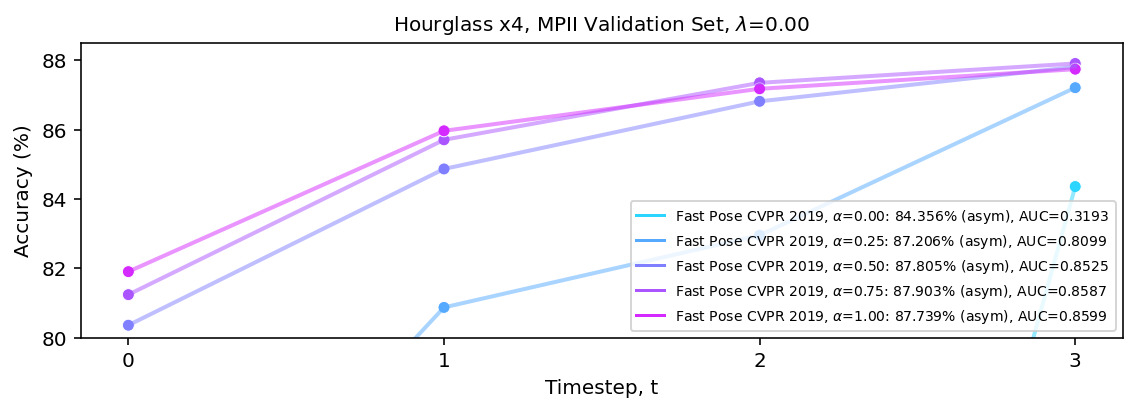

<Figure size 432x288 with 0 Axes>

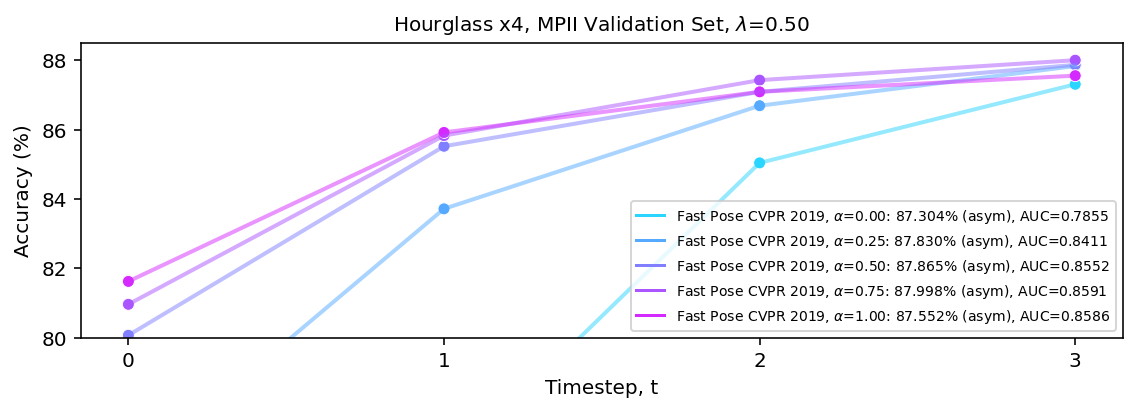

<Figure size 432x288 with 0 Axes>

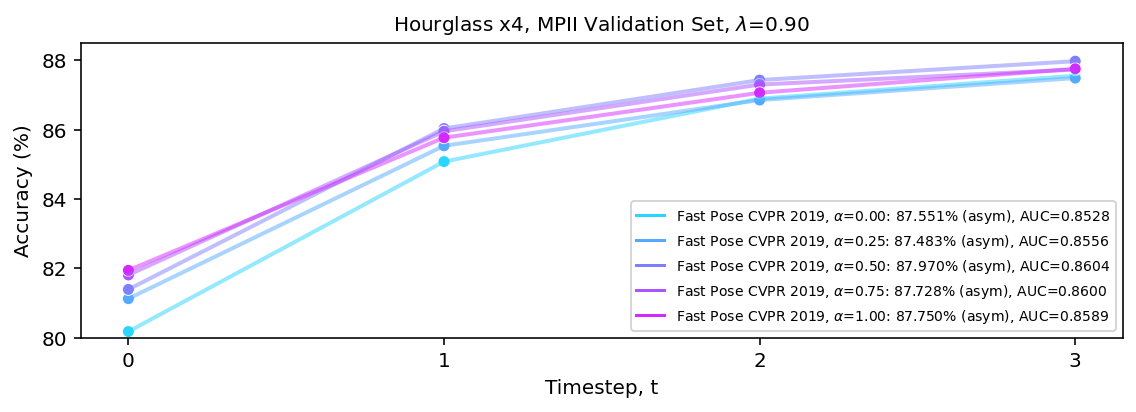

<Figure size 432x288 with 0 Axes>

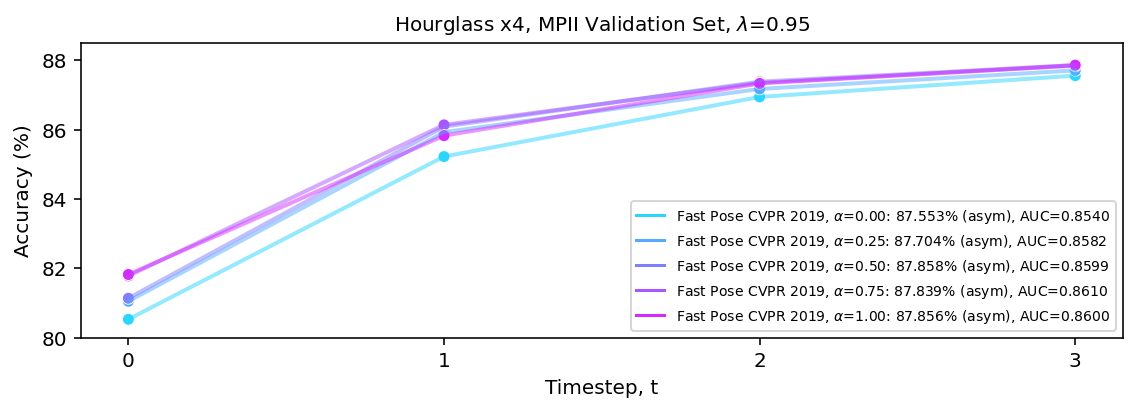

<Figure size 432x288 with 0 Axes>

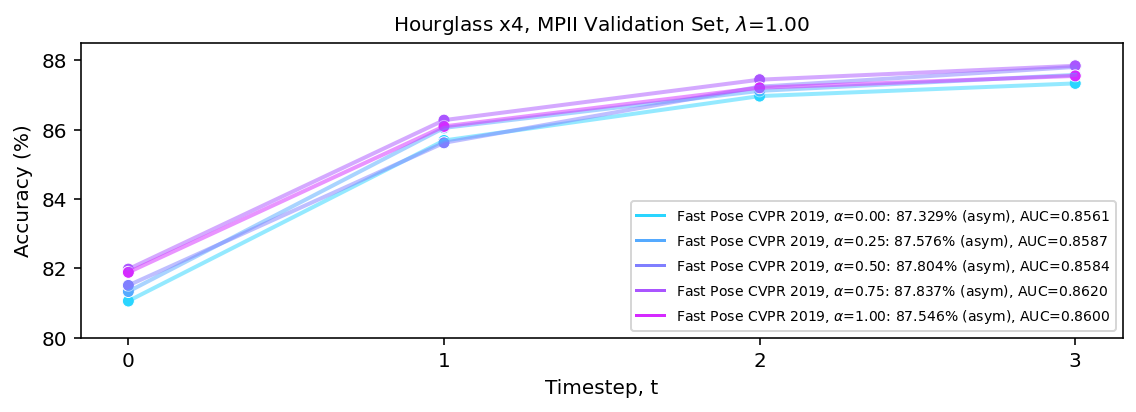

<Figure size 432x288 with 0 Axes>

In [131]:
for td_val, td_df in df.groupby("td"):
  distillation_df = td_df[td_df.distillation]
  ylim_max = float(distillation_df.val.max())
  ylim_max += 5
  SHOW_DIST = True
  distillation_df = distillation_df[distillation_df.t < 4]
  for model_key, td_model_df in distillation_df.groupby("model"):
    plot_figure(
        td_model_df, 
        dataset_name=DATASET_NAME, 
        baseline_df=None,
        ylim_min=80,
        ylim_max=88.5,
        show_dist=SHOW_DIST,
        legend_font_size=7,
        val_at_t=None,
        dist_cmap=plt.cm.cool,
        dist_ls="-",
        add_auc=True,
        key_val=td_val,
        key="alpha",
    )
    plt.tight_layout()
    save_path = os.path.join("figs", f"{model_key}__speed_acc__lambda={td_val:0.2f}.pdf")
    plt.savefig(save_path, dpi=300)
    plt.savefig(save_path.replace(".pdf", ".png"), dpi=300)
    
    plt.show()
    plt.clf()

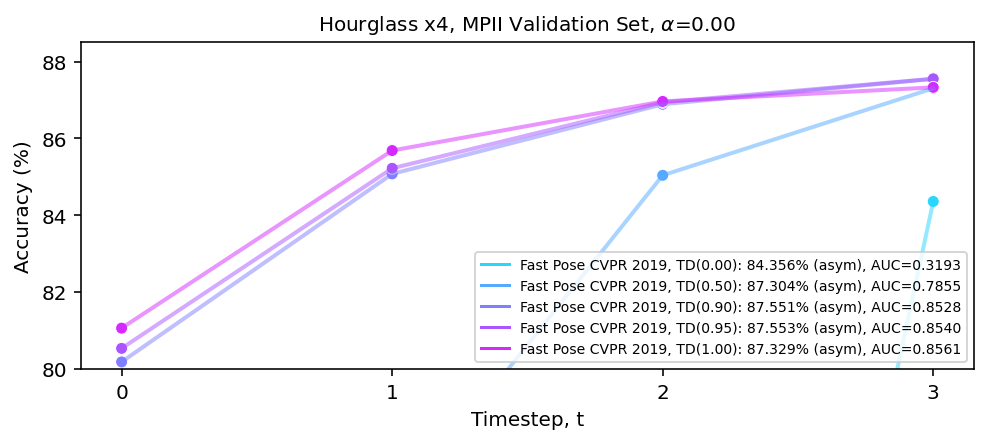

<Figure size 432x288 with 0 Axes>

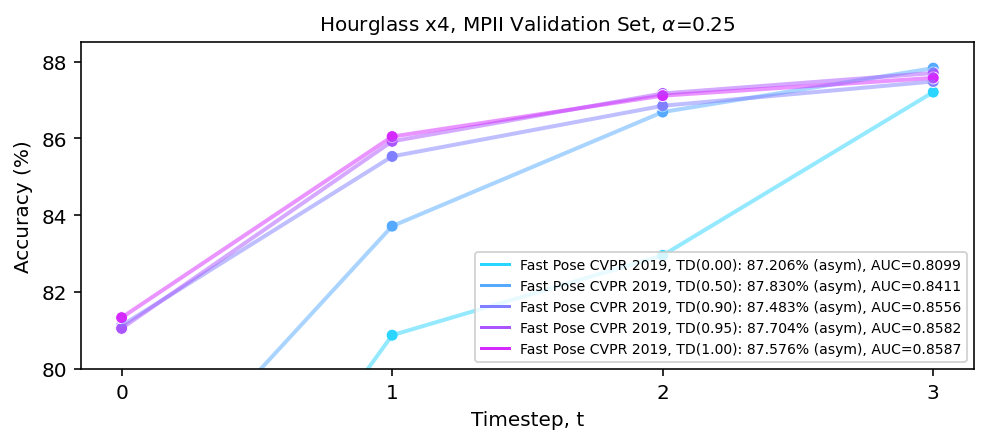

<Figure size 432x288 with 0 Axes>

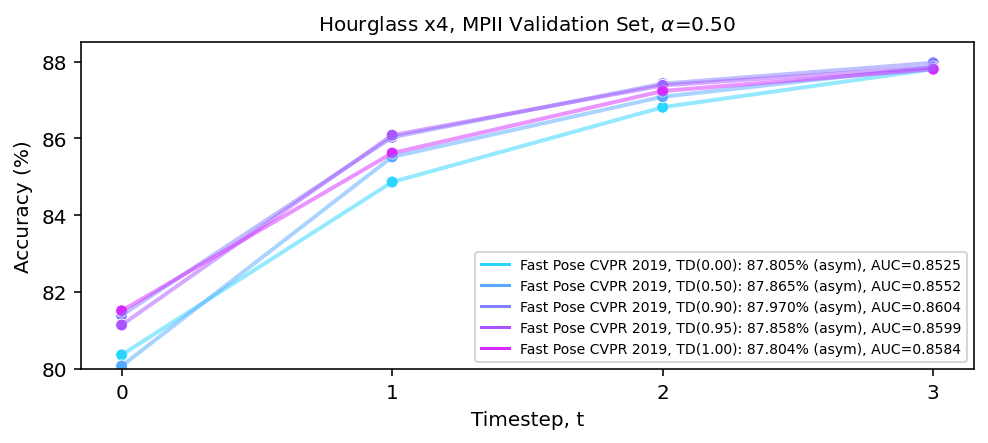

<Figure size 432x288 with 0 Axes>

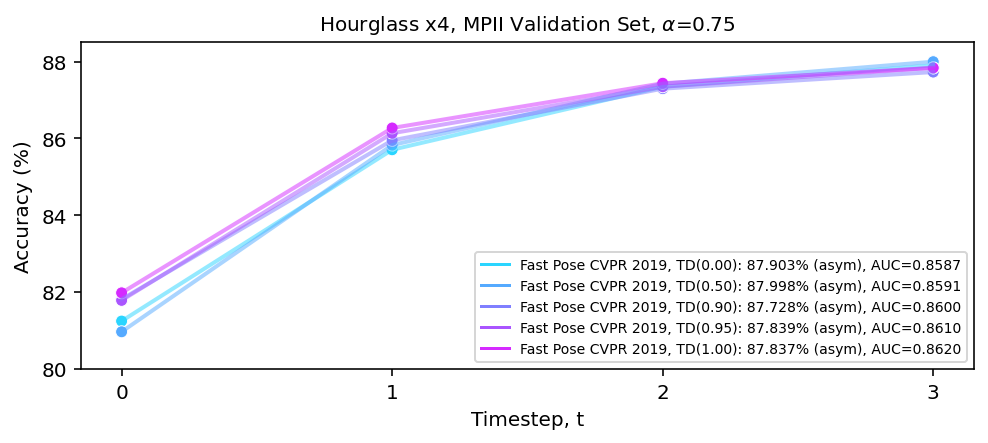

<Figure size 432x288 with 0 Axes>

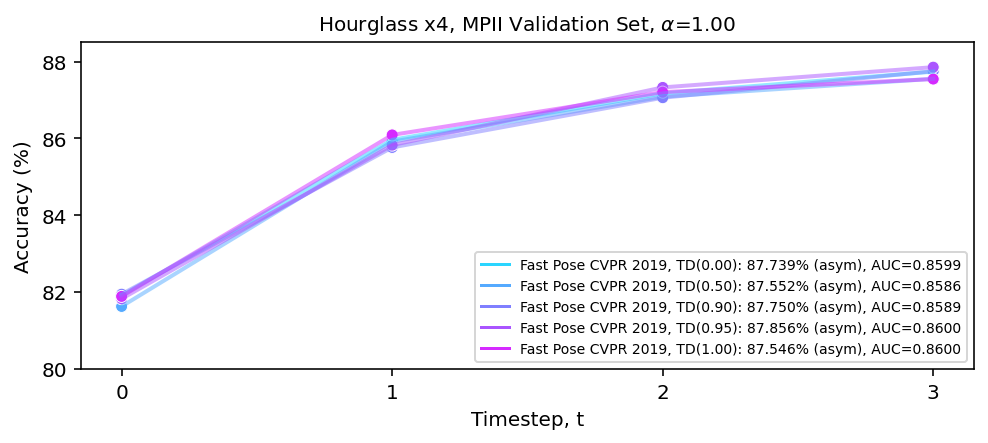

<Figure size 432x288 with 0 Axes>

In [130]:
for alpha_val, alpha_df in df.groupby("alpha"):
  distillation_df = alpha_df[alpha_df.distillation]
  ylim_max = float(distillation_df.val.max())
  ylim_max += 5
  SHOW_DIST = True
  distillation_df = distillation_df[distillation_df.t < 4]
  for model_key, td_model_df in distillation_df.groupby("model"):
    plot_figure(
        td_model_df, 
        dataset_name=DATASET_NAME, 
        baseline_df=None,
        ylim_min=80,
        ylim_max=88.5,
        show_dist=SHOW_DIST,
        legend_font_size=7,
        val_at_t=None,
        dist_cmap=plt.cm.cool,
        dist_ls="-",
        add_auc=True,
        key_val=alpha_val,
        key="td",
    )
    plt.tight_layout()
    save_path = os.path.join("figs", f"{model_key}__speed_acc__alpha={alpha_val:0.2f}.pdf")
    plt.savefig(save_path, dpi=300)
    plt.savefig(save_path.replace(".pdf", ".png"), dpi=300)
    
    plt.show()
    plt.clf()

### Lambda vs. Acc per Timestep

In [13]:
# for alpha_val, alpha_df in df.groupby("alpha"):
#   distillation_df = alpha_df[alpha_df.distillation]
#   distillation_df = distillation_df[distillation_df.t > 0]
#   color_lookup = make_color_lookup(distillation_df, key="t", cmap=plt.cm.magma)
#   plt.figure(figsize=(7,4))
#   for t, td_df in distillation_df.groupby("t"):
#     color_i = color_lookup[t]
#     g = sns.lineplot(
#         x="td", 
#         y="val", 
#         data=td_df, 
#         lw=3,
#         color=color_i, 
#         alpha=0.5,
#         label=f"t={t}",
#     )
#     g = sns.scatterplot(x="td", y="val", data=td_df, color=color_i)

#   g.set(xlabel=r"lambda, $\lambda$", ylabel="Accuracy (%)")
#   g.set_title(r"Accuracy vs. Lambda per Timestep, $\alpha$={}".format(alpha_val))
#   plt.show()

### Alpha vs. TD Lambda

In [14]:
def plot_arrow(
    g, 
    text, 
    x_start=0.0, 
    x_length=1.0, 
    y=5.5, 
    arrowstyle="->", 
    text_delta=0.22,
    fs=10.0,
):
  x_end = x_start + x_length
  g.annotate(
      s=" ",
      xy=(x_start, y), 
      xycoords='data',
      xytext=(x_end, y),
      textcoords='data',
      fontsize=fs,
      arrowprops=dict(arrowstyle=arrowstyle),
      va='center',
      annotation_clip=False,
  )
  g.annotate(
      s=text,
      xy=(((x_start + x_end)/2), y + text_delta),
      xycoords='data',
      fontsize=fs,
      textcoords='data',
      ha='center',
      annotation_clip=False,
  )

In [15]:
def fill_df(asymptotic_df):
  new_dfs = []
  for td in asymptotic_df.td.unique():
    td_df = asymptotic_df[asymptotic_df.td == td]
    alphas = [float(ele) for ele in td_df.alpha.unique()]
    for alpha in [0.0, 0.25, 0.5, 0.75, 1.0]:
      if alpha not in alphas:
        new_df = pd.DataFrame({"td": [td], "alpha": [alpha], "val": [0.0]})
        new_dfs.append(new_df)
  new_dfs = pd.concat(new_dfs)
  
  
  new_asymptotic_df = pd.concat([asymptotic_df, new_dfs])
  
  new_asymptotic_df = new_asymptotic_df.sort_values(by=["td", "alpha"])
  new_asymptotic_df.reset_index(drop=True, inplace=True)

  return new_asymptotic_df

/home/michael/anaconda3/envs/pest/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/michael/anaconda3/envs/pest/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


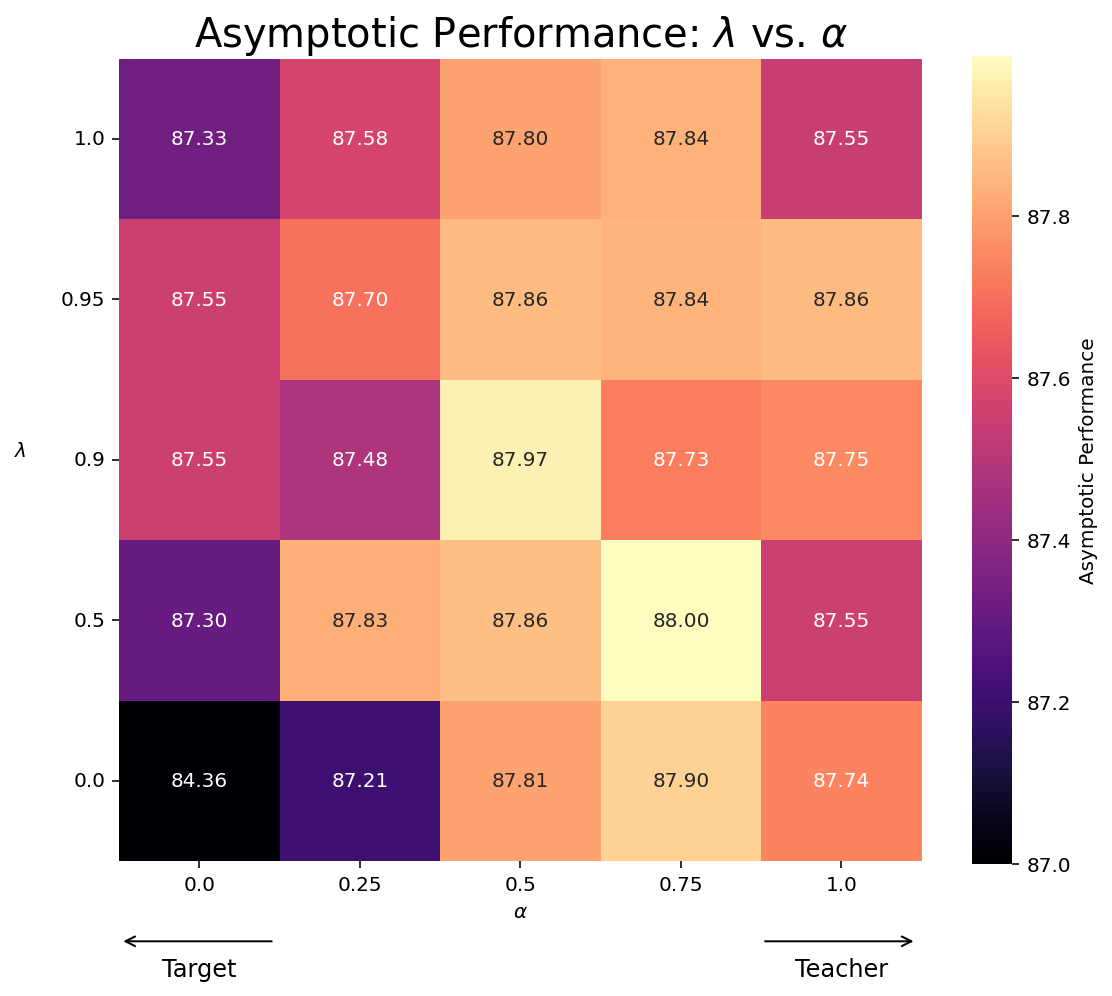

In [49]:
VMIN = 87.0  # 86.5

distillation_df = full_df[full_df.distillation]
asymptotic_df = distillation_df[distillation_df.t==distillation_df.t.max()]
asymptotic_df = asymptotic_df[["td", "alpha", "val"]]
asymptotic_df["td"] = [float(ele) for ele in asymptotic_df.td]
asymptotic_df["alpha"] = [float(ele) for ele in asymptotic_df.alpha]
asymptotic_df = asymptotic_df.sort_values(by=["td", "alpha"])
try:
  asymptotic_df = fill_df(asymptotic_df)
except ValueError:
  pass

# pivot the dataframe from long to wide form
result = asymptotic_df.pivot(index="td", columns="alpha", values="val")
cols = list(np.sort(result.columns.tolist()))
result = result[cols]
result = result.iloc[::-1]

plt.figure(figsize=(8,8))
mask = np.zeros_like(result)
mask[np.where(result==0)] = True

g = sns.heatmap(
    result, 
    mask=mask,
    annot=True, 
    fmt="0.2f", 
    cmap="magma", 
    square=True,
    cbar_kws={"label": "Asymptotic Performance", "shrink": 0.75},
    vmin=VMIN,
)
g.set_xlabel(r"$\alpha$")
g.set_ylabel(r"$\lambda$", rotation=0, labelpad=20)
plt.yticks(rotation=0)
plot_arrow(g, x_start=0.0, text="Target", arrowstyle="->", fs=12)
plot_arrow(g, x_start=4.0, text="Teacher", arrowstyle="<-", fs=12)
plt.title(r"Asymptotic Performance: $\lambda$ vs. $\alpha$", fontsize=20)
plt.tight_layout()
pdf_save_path = os.path.join(figs_root, "asymptotic_plot.pdf")
plt.savefig(pdf_save_path, dpi=300)
png_save_path = os.path.join(figs_root, "asymptotic_plot.png")
plt.savefig(png_save_path, dpi=300)

plt.show()

/home/michael/anaconda3/envs/pest/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/michael/anaconda3/envs/pest/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


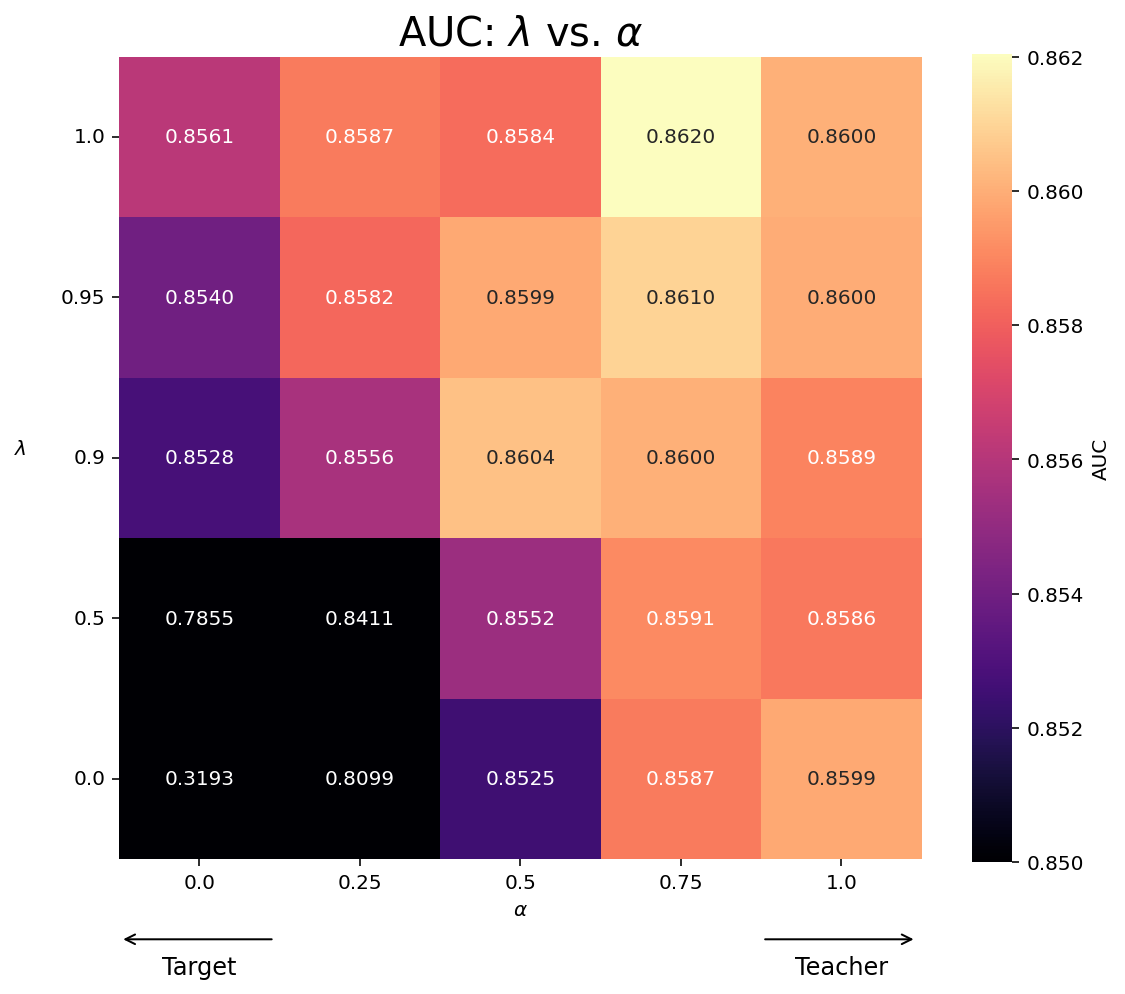

In [50]:
VMIN = 0.85

distillation_df = full_df[full_df.distillation]
df_dict = defaultdict(list)
for td_key, td_df in distillation_df.groupby("td"):
  for alpha, alpha_df in td_df.groupby("alpha"):
    vals = np.array(alpha_df.val)
    auc_val = np.trapz(vals) / np.trapz([100 for _ in vals])
    df_dict["td"].append(td_key)
    df_dict["alpha"].append(alpha)
    df_dict["auc"].append(auc_val)
auc_df = pd.DataFrame(df_dict)
auc_df = auc_df[["td", "alpha", "auc"]]
auc_df["td"] = [float(ele) for ele in auc_df.td]
auc_df["alpha"] = [float(ele) for ele in auc_df.alpha]
auc_df = auc_df.sort_values(by=["td", "alpha"])
try:
  auc_df = fill_df(auc_df)
except ValueError:
  pass

# pivot the dataframe from long to wide form
result = auc_df.pivot(index="td", columns="alpha", values="auc")
cols = list(np.sort(result.columns.tolist()))
result = result[cols]
result = result.iloc[::-1]

plt.figure(figsize=(8,8))
mask = np.zeros_like(result)
mask[np.where(result==0)] = True

g = sns.heatmap(
    result, 
    mask=mask,
    annot=True, 
    fmt="0.4f", 
    cmap="magma", 
    square=True,
    cbar_kws={"label": "AUC", "shrink": 0.75},
    vmin=VMIN,
)
g.set_xlabel(r"$\alpha$")
g.set_ylabel(r"$\lambda$", rotation=0, labelpad=20)
plt.yticks(rotation=0)
plot_arrow(g, x_start=0.0, text="Target", arrowstyle="->", fs=12)
plot_arrow(g, x_start=4.0, text="Teacher", arrowstyle="<-", fs=12)
plt.title(r"AUC: $\lambda$ vs. $\alpha$", fontsize=20)
plt.tight_layout()
pdf_save_path = os.path.join(figs_root, "auc_plot.pdf")
plt.savefig(pdf_save_path, dpi=300)
png_save_path = os.path.join(figs_root, "auc_plot.png")
plt.savefig(png_save_path, dpi=300)

plt.show()